# Solargis task

### Description

<font size="2">You will be given a data set containing two model forecasts and the actually observed weather. Your task
is to determine which forecast performs the best according to you. You are free to select the metrics that
you want to use. Nevertheless, we expect you to deliver an opinion on which model is more accurate,
backed by short argumentation in written form as well as a piece of code used to analyse the data -
preferably a python script or notebook. Figures are welcome.

<font size="2">The netCDF4 format used for data is a binary hierarchical multidimensional array storage, based on HDF.
It can be read, for example, by netCDF or xarray python libraries.

<font size="2">The models are forecasting Global Horizontal Irradiance, which is the total amount of solar irradiation
that is received by a horizontal plane on the ground. Each forecast is 4 hours long in steps of 10 min. It is
based on data obtained from the GOES-R satellite.

<font size="2">Chile is an interesting region to compare forecasts due to the variety in geography. The region included in
the data cube has ocean, a coastal plane, two high altitude planes at ~2000 and ~4000 m, and includes the
Andes.

The models are 4 dimensional:
- reference_time: This is the date-time of the start of the forecast.
- lead_time: The timedelta of the forecast image compared to the reference time
- latitude: latitude in degrees north
- longitude: longitude in degrees east
The observed data is 3 dimensional (reference_time, latitude and longitude).
Also included is an elevation map of the region.

<font size="2">Note: model_1 is calculated for all reference time slots during the local day, model_2 is only calculated
for every 5th
time slot.

In [1]:
import netCDF4 as nc
import numpy as np
import numba as nb
import multiprocessing as mp
import matplotlib.pyplot as plt
from datetime import datetime
from mpl_toolkits.basemap import Basemap

<font size="3">I have chosen netCDF library for reading the data. "nc" file loaded with dataset

In [2]:
ds = nc.Dataset('nowcast_validation_sample_goesr_chile.nc', 'r+')

### Dataset analysis

The dataset consists of these variables:
- reference time: actual time measured in minutes from 1.1.1970, array of shape [4320]
- lead time: time increment from reference time: 25x10 minute intervals from reference time 
- latitude: latitude in degrees north
- longitude: longitude in degrees east
- model_1: data for 1.st model, array of shape [4320, 25, 300, 300] ([ref_time_idx, delta_idx, lat_idx, long_idx])
- model_2: data for 2.nd model, array of shape [4320, 25, 300, 300] ([ref_time_idx, delta_idx, lat_idx, long_idx])
- observed: actual data from measurements, array of shape [4320, 300, 300] (without model simulation delta steps) 
- elevation: elevation in meters from sea level

In [3]:
ds.variables.keys()

dict_keys(['reference_time', 'lead_time', 'latitude', 'longitude', 'model_1', 'model_2', 'observed', 'elevation'])

<font size="4">The time window for chosen dataset is an April's data of 2021

In [4]:
str(datetime.fromtimestamp(ds.variables['reference_time'][0]*60)), str(datetime.fromtimestamp(ds.variables['reference_time'][-1]*60))

('2021-04-01 02:00:00', '2021-05-01 01:50:00')

<font size="4">Visualization of the area using Basemap. In the map we can see South America west coast of Chille.  

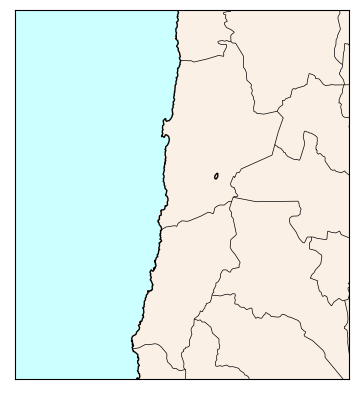

In [5]:
lat = ds.variables['latitude'][:]
long = ds.variables['longitude'][:]

chille_map = Basemap(
    projection='merc', 
    llcrnrlon=np.min(long), 
    llcrnrlat=np.min(lat), 
    urcrnrlon=np.max(long), 
    urcrnrlat=np.max(lat), 
    resolution= 'i')

chille_map.drawcoastlines()
chille_map.drawstates()
chille_map.drawcountries()
chille_map.drawcounties()
chille_map.drawlsmask(land_color='Linen', ocean_color='#CCFFFF')

In [6]:
# Helper function for dataset visualization

def plot_regional_data(data=None, ax=None):
    
    chille_map = Basemap(
    projection='merc',
    llcrnrlon=np.min(long),
    llcrnrlat=np.min(lat),
    urcrnrlon=np.max(long),
    urcrnrlat=np.max(lat),
    resolution='i',
    ax=ax)
    
    parallels = np.arange(round(np.min(lat)), round(np.max(lat)),2.)
    meridians = np.arange(round(np.min(long)), round(np.max(long)),2.)
    
    chille_map.drawcoastlines()
    chille_map.drawstates()
    chille_map.drawcountries()
    chille_map.drawcounties()
    chille_map.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
    chille_map.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)

    lons,lats = np.meshgrid(long, lat)

    x,y = chille_map(lons,lats)
    if data is not None:
        data_viz = chille_map.contourf(x,y,data)
        cb = chille_map.colorbar(data_viz,"bottom", size="5%", pad="7%")
    elevattion_viz = chille_map.contour(x,y,ds.variables['elevation'][:],5,cmap='hot_r', linewidths=0.5)

<font size="4">Default visualization background is chosen this way for better orientation in the simulated area.

<font size="4">We can see boarers of continents and counties with contourplot of elevation.

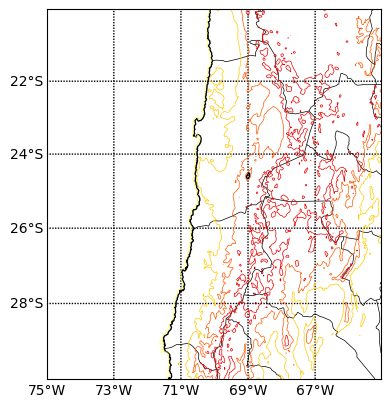

In [7]:
plot_regional_data()

<font size="3">With impleneted `plot_regional_data` function we can visualize the data for models and observed. As we can see first datapoint is empty as it is probably night time in the area and therefore no data are obtiained:

/home/semo/anaconda3/envs/solargis37/lib/python3.7/site-packages/matplotlib/contour.py:1491: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/semo/anaconda3/envs/solargis37/lib/python3.7/site-packages/matplotlib/contour.py:1492: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/home/semo/anaconda3/envs/solargis37/lib/python3.7/site-packages/matplotlib/contour.py:1491: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/semo/anaconda3/envs/solargis37/lib/python3.7/site-packages/matplotlib/contour.py:1492: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/home/semo/anaconda3/envs/solargis37/lib/python3.7/site-packages/matplotlib/contour.py:1491: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/semo/anaconda3/envs/solargis37/lib/python3.7/site-packages/matplotlib/contour.py:1492: UserWar

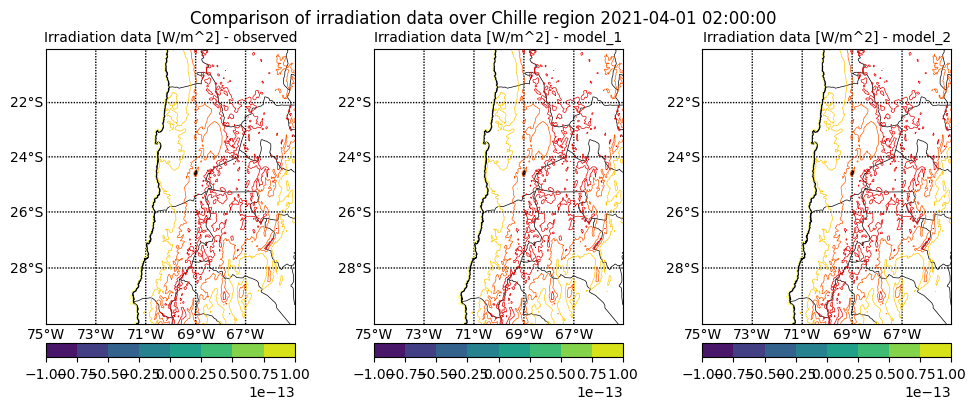

In [8]:
ref_idx = 0
delta = 0

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[12,4])
fig.suptitle('Comparison of irradiation data over Chille region '+ 
             str(datetime.fromtimestamp(ds.variables['reference_time'][ref_idx]*60)), fontsize=12)
ax[0].set_title('Irradiation data [W/m^2] - observed', size=10)
ax[1].set_title('Irradiation data [W/m^2] - model_1', size=10)
ax[2].set_title('Irradiation data [W/m^2] - model_2', size=10)
plot_regional_data(ds.variables['observed'][ref_idx+delta], ax[0])
plot_regional_data(ds.variables['model_1'][ref_idx,delta], ax[1])
plot_regional_data(ds.variables['model_2'][ref_idx,delta], ax[2])

<font size="4">We must find datapoints in dataset, which have relevant data for comparison. Underlying code should find the indexes of datapoints, which are relevant for futher model comparison analysis. We are selecting indexes for dataset where data are not masked and does not consist of nan values.

In [7]:
def datapoint_filter(idx):
    model_1_filter = isinstance(ds.variables['model_1'][idx].mask, np.bool_) and np.sum(np.isnan(ds.variables['model_1'][idx]))==0.0
    model_2_filter = isinstance(ds.variables['model_2'][idx].mask, np.bool_) and np.sum(np.isnan(ds.variables['model_2'][idx]))==0.0
    return model_1_filter, model_2_filter

reference_idxs_model1 = []
reference_idxs_model2 = []

with mp.Pool() as pool:
    
    for i, model_filter in enumerate(pool.map(datapoint_filter, range(4320))):

        if model_filter[0]:
            reference_idxs_model1.append(i)

        if model_filter[1]:
            reference_idxs_model2.append(i)
        
model1_ref_idxs = np.array(reference_idxs_model1)
model2_ref_idxs = np.array(reference_idxs_model2)

In [10]:
model1_ref_idxs

array([  70,   71,   72, ..., 4279, 4280, 4281])

In [11]:
model2_ref_idxs # model2 two has 5x less datapoints than model1

array([  72,   77,   82,   87,   92,   97,  102,  107,  216,  221,  226,
        231,  236,  241,  246,  251,  360,  365,  370,  375,  380,  385,
        390,  395,  504,  509,  514,  519,  524,  529,  534,  539,  648,
        653,  658,  663,  668,  673,  678,  683,  792,  797,  802,  807,
        812,  817,  822,  827,  936,  941,  946,  951,  956,  961,  966,
        971, 1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1224, 1229,
       1234, 1239, 1244, 1249, 1254, 1259, 1368, 1373, 1378, 1383, 1388,
       1393, 1398, 1403, 1512, 1517, 1522, 1527, 1532, 1537, 1542, 1547,
       1656, 1661, 1666, 1671, 1676, 1681, 1686, 1691, 1800, 1805, 1810,
       1815, 1820, 1825, 1830, 1835, 1944, 1949, 1954, 1959, 1964, 1969,
       1974, 1979, 2088, 2093, 2098, 2103, 2108, 2113, 2118, 2123, 2232,
       2237, 2242, 2247, 2252, 2257, 2262, 2267, 2376, 2381, 2386, 2391,
       2396, 2401, 2406, 2521, 2526, 2534, 2539, 2544, 2549, 2554, 2665,
       2670, 2675, 2680, 2685, 2690, 2695, 2809, 28

<font size="4">Here from the first sight, we can see that overlapping index "72" for both models. Let's visualize it:

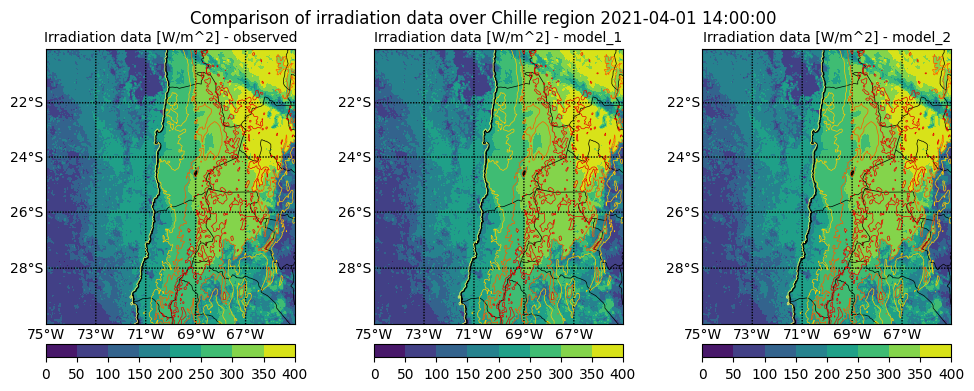

In [12]:
ref_idx = 72
delta = 0

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[12,4])
fig.suptitle('Comparison of irradiation data over Chille region '+ 
             str(datetime.fromtimestamp(ds.variables['reference_time'][ref_idx]*60)), fontsize=12)
ax[0].set_title('Irradiation data [W/m^2] - observed', size=10)
ax[1].set_title('Irradiation data [W/m^2] - model_1', size=10)
ax[2].set_title('Irradiation data [W/m^2] - model_2', size=10)
plot_regional_data(ds.variables['observed'][ref_idx+delta], ax[0])
plot_regional_data(ds.variables['model_1'][ref_idx,delta], ax[1])
plot_regional_data(ds.variables['model_2'][ref_idx,delta], ax[2])

<font size="4">Here we can see that the data are the same for all three data subsets. It is because at reference times with time `delta=0` the initial condition should be the same for all three data subsets. Lets see how models will drift away from real data with setting `delta=15` (just random pick)

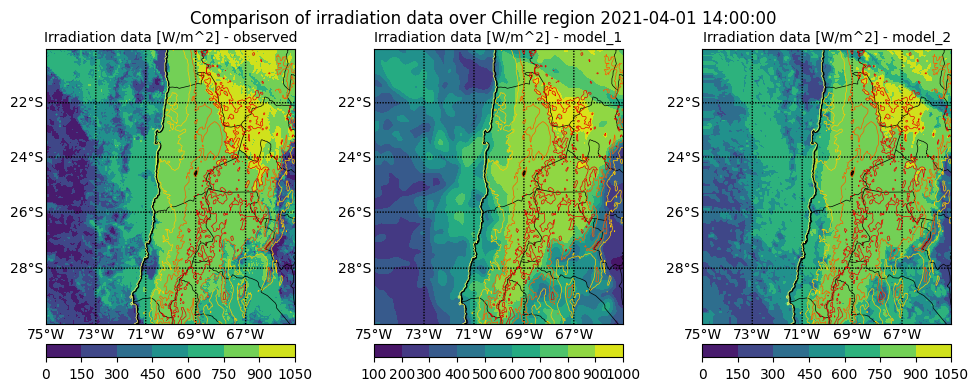

In [13]:
ref_idx = 72
delta = 15

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[12,4])
fig.suptitle('Comparison of irradiation data over Chille region '+ 
             str(datetime.fromtimestamp(ds.variables['reference_time'][ref_idx]*60)), fontsize=12)
ax[0].set_title('Irradiation data [W/m^2] - observed', size=10)
ax[1].set_title('Irradiation data [W/m^2] - model_1', size=10)
ax[2].set_title('Irradiation data [W/m^2] - model_2', size=10)
plot_regional_data(ds.variables['observed'][ref_idx+delta], ax[0])
plot_regional_data(ds.variables['model_1'][ref_idx,delta], ax[1])
plot_regional_data(ds.variables['model_2'][ref_idx,delta], ax[2])

<font size="4">From the last figure we can see qualitative behavior of both models. Model1 seems to be more simplistic (based on the coarser granularity of simulated structures compared to model2) and probably requires less computational power (based on the fact that it is computed for each time step compared to model2)</font>

### Data manipulation note

During data processing I found glitches in observed data on indexes [2529, 4014]

I found them by this filter:

In [14]:
mean_observed_data = np.array([np.mean(x) for x in ds.variables['observed'][:]]) 

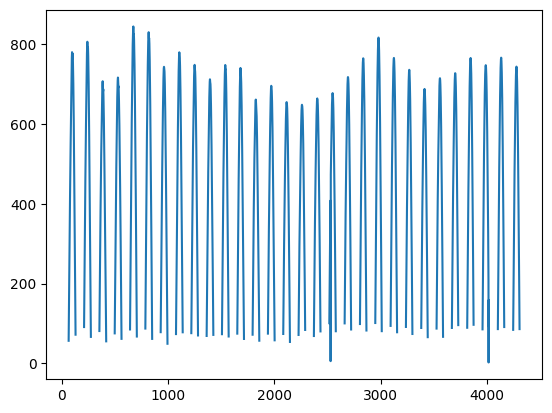

In [15]:
plt.plot(mean_observed_data)

I decided to change the data with this filter by removing reference indexes from our scope of interest and interpolating the data 

In [16]:
ds.variables['observed'][4014] = np.copy(ds.variables['observed'][4013] + ds.variables['observed'][4015])/2
ds.variables['observed'][2529] = np.copy(ds.variables['observed'][2528] + ds.variables['observed'][2530])/2

model1_ref_idxs = model1_ref_idxs[~((model1_ref_idxs == 4014) & (model1_ref_idxs == 2529))]
model2_ref_idxs = model2_ref_idxs[~((model2_ref_idxs == 4014) & (model2_ref_idxs == 2529))]

ds.close()
ds = nc.Dataset('nowcast_validation_sample_goesr_chile.nc', 'r+')

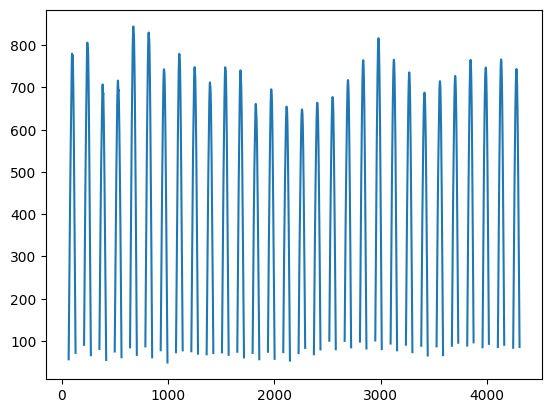

In [17]:
mean_observed_data = np.array([np.mean(x) for x in ds.variables['observed'][:]]) 
plt.plot(mean_observed_data)

<font size="4">After this manipulation were data somehow artificially changed, hopefully in logical manner as we got rid of glitches

### Statistical analysis

<font size="4">One of the commonly used KPIs for weather forecasting is calculation of statistical moments for absolute percentage error (APE). <font size="4">Definition of absolute percentage error is given by formula:

$$\begin{equation}
APE = \left|\frac{X_{\text{predicted}} - X_{\text{observed}}}{X_{\text{observed}}}\right|
\end{equation}$$

In [8]:
@nb.njit
def calculate_absolute_percentage_error(observed, predicted):
    return np.abs(predicted - observed)/observed

<font size="4">Lets visualize what the absolute percentage error looks like on the map

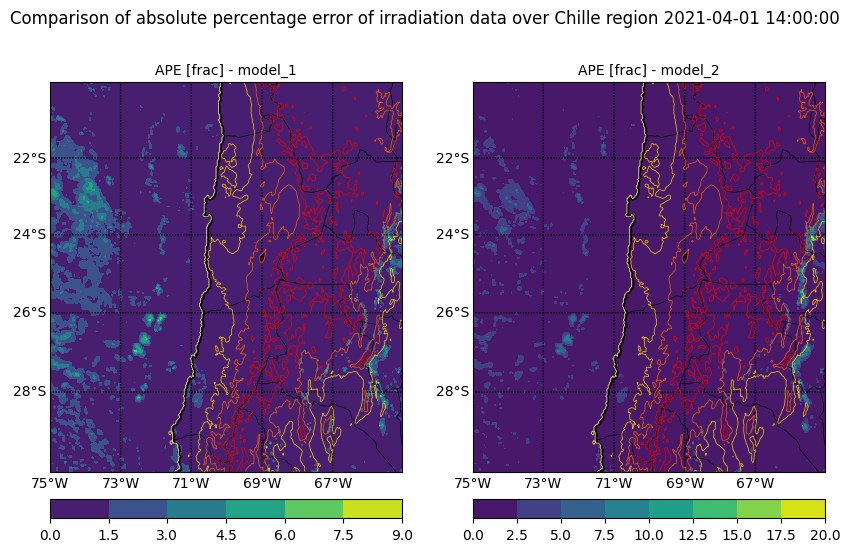

In [15]:
ref_idx = 72
delta = 15

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[10,6])
fig.suptitle('Comparison of absolute percentage error of irradiation data over Chille region '+ 
             str(datetime.fromtimestamp(ds.variables['reference_time'][ref_idx]*60)), fontsize=12)
ax[0].set_title('APE [frac] - model_1', size=10)
ax[1].set_title('APE [frac] - model_2', size=10)

ape_model_1 = calculate_absolute_percentage_error(ds.variables['observed'][ref_idx+delta], 
                                                  ds.variables['model_1'][ref_idx, delta])

ape_model_2 = calculate_absolute_percentage_error(ds.variables['observed'][ref_idx+delta], 
                                                  ds.variables['model_2'][ref_idx, delta])


plot_regional_data(ape_model_1, ax[0])
plot_regional_data(ape_model_2, ax[1])

<font size="4">As we can see, model_2 has much higher range of deviations in some areas (mainly nearby eastern side of Andes). Both models tend to have higher error rate in the lower elevation places. Lets see mean and median of the error rates in the area.

In [16]:
print('Mean absolute percentage error')
print(f'model_1 : {round(np.mean(ape_model_1)*100, 2)} %')
print(f'model_2 : {round(np.mean(ape_model_2)*100, 2)} %')
print(' ')
print('Median absolute percentage error')
print(f'model_1 : {round(np.median(ape_model_1)*100, 2)} %')
print(f'model_2 : {round(np.median(ape_model_2)*100, 2)} %')

Mean absolute percentage error
model_1 : 42.62 %
model_2 : 50.74 %
 
Median absolute percentage error
model_1 : 12.91 %
model_2 : 16.36 %


<font size="4">Median was chosen for cutting off too deviated areas in the area. Both median and mean APE tend to be higher for model_2

<font size="4">Let's see whether there is any difference of APE dependent on elevation level

/home/semo/anaconda3/envs/solargis37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/semo/anaconda3/envs/solargis37/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


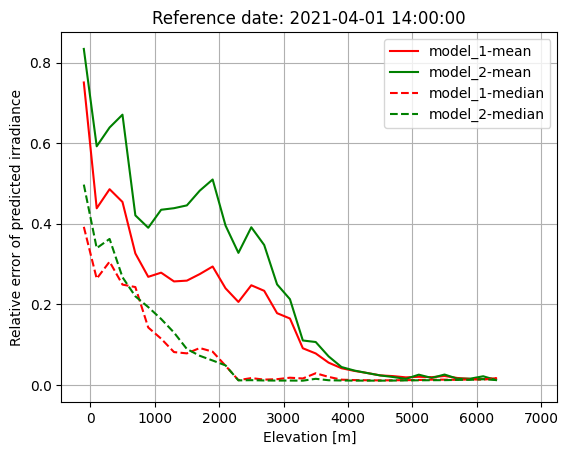

In [17]:
def mask_by_elevation(upper, lower):
    return (ds.variables['elevation'][:]>lower)*(ds.variables['elevation'][:]<upper)

elevation_levels = np.arange(-100, 7000, 200)

model_1_mean_error_elevation = np.zeros_like(elevation_levels, dtype=float)
model_2_mean_error_elevation = np.zeros_like(elevation_levels, dtype=float)

model_1_median_error_elevation = np.zeros_like(elevation_levels, dtype=float)
model_2_median_error_elevation = np.zeros_like(elevation_levels, dtype=float)

for i, level in enumerate(elevation_levels[:-1]):
    elevation_mask = mask_by_elevation(elevation_levels[i+1], level)
    model_1_mean_error_elevation[i] = np.mean(ape_model_1[elevation_mask])
    model_2_mean_error_elevation[i] = np.mean(ape_model_2[elevation_mask])
    model_1_median_error_elevation[i] = np.median(ape_model_1[elevation_mask])
    model_2_median_error_elevation[i] = np.median(ape_model_2[elevation_mask])

plt.plot(elevation_levels,model_1_mean_error_elevation, color='red', label='model_1-mean')
plt.plot(elevation_levels,model_2_mean_error_elevation, color='green', label='model_2-mean')
plt.plot(elevation_levels,model_1_median_error_elevation,'--', color='red', label='model_1-median')
plt.plot(elevation_levels,model_2_median_error_elevation,'--', color='green', label='model_2-median')

plt.legend(loc='best')
plt.ylabel('Relative error of predicted irradiance')
plt.xlabel('Elevation [m]')
plt.title('Reference date: '+ str(datetime.fromtimestamp(ds.variables['reference_time'][ref_idx]*60)))
plt.grid(True)

<font size="4">Based on this figure we can see that mean error values are always higher for model_2 than model_1. However median values have some elevation places where the error are slighly higher for model_1. In all the plots, we can see decreasing error tendency with higher elevation level. This effect is probably due to lower complexity of atmospheric efects in these altitudes.

<font size="4">Next question could be whether one of the model is more precise for some delta step range

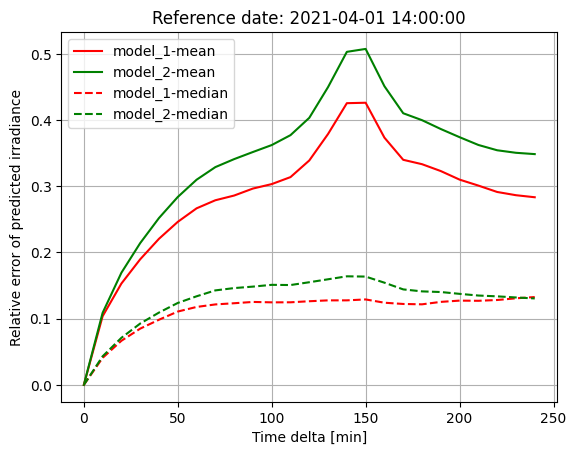

In [22]:
time_delta = np.arange(25)
model_1_mean_error_time_delta = np.zeros_like(time_delta, dtype=float)
model_2_mean_error_time_delta = np.zeros_like(time_delta, dtype=float)
model_1_median_error_time_delta = np.zeros_like(time_delta, dtype=float)
model_2_median_error_time_delta = np.zeros_like(time_delta, dtype=float)

for delta in time_delta:
    
    ape_model_1 = calculate_absolute_percentage_error(ds.variables['observed'][ref_idx+delta], 
                                                  ds.variables['model_1'][ref_idx, delta])

    ape_model_2 = calculate_absolute_percentage_error(ds.variables['observed'][ref_idx+delta], 
                                                  ds.variables['model_2'][ref_idx, delta])
    
    model_1_mean_error_time_delta[delta] = np.mean(ape_model_1)
    model_2_mean_error_time_delta[delta] = np.mean(ape_model_2)
    model_1_median_error_time_delta[delta] = np.median(ape_model_1)
    model_2_median_error_time_delta[delta] = np.median(ape_model_2)
    
plt.plot(time_delta*10,model_1_mean_error_time_delta, color='red', label='model_1-mean')
plt.plot(time_delta*10,model_2_mean_error_time_delta, color='green', label='model_2-mean')
plt.plot(time_delta*10,model_1_median_error_time_delta,'--', color='red', label='model_1-median')
plt.plot(time_delta*10,model_2_median_error_time_delta,'--', color='green', label='model_2-median')
plt.legend(loc='best')
plt.ylabel('Relative error of predicted irradiance')
plt.xlabel('Time delta [min]')
plt.title('Reference date: '+ str(datetime.fromtimestamp(ds.variables['reference_time'][ref_idx]*60)))
plt.grid(True)

<font size="3">This figure has shown the better (lower error) behavior for model_1 delta-wise. In the figure interesting effect of error rate dependency on rclock time according to peaks for both error curves at 150 min (12:00AM) - higher the total irradiance is, higher error rate it implies.

<font size="3">Another statistical quantity could be number of frames/places where the error is higher/lower compared to the other model. In the next figure we will visiualize in how many places is absolute percentage error for model_1 higher that for model_2. All the yellow places are points where APE is hifgher for model_1 or in other words: model_2 has better local accuracy. 

Text(0.5, 1.0, 'APE difference - model_1>model_2 mask')

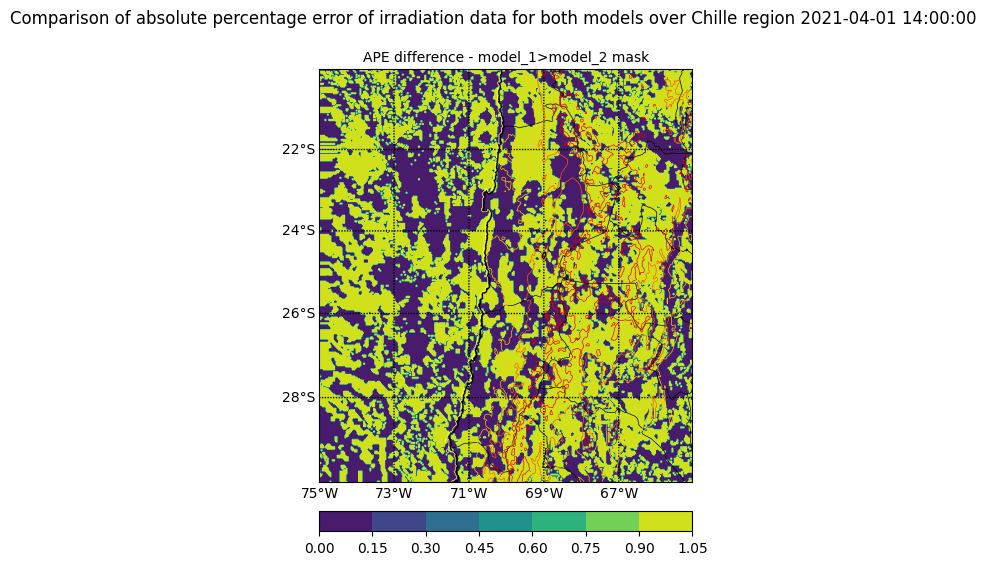

In [23]:
ref_idx = 72
delta = 15


ape_model_1 = calculate_absolute_percentage_error(ds.variables['observed'][ref_idx+delta], 
                                                  ds.variables['model_1'][ref_idx, delta])

ape_model_2 = calculate_absolute_percentage_error(ds.variables['observed'][ref_idx+delta], 
                                                  ds.variables['model_2'][ref_idx, delta])

comparison_mask = ape_model_1>ape_model_2

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[10,6])
fig.suptitle('Comparison of absolute percentage error of irradiation data for both models over Chille region '+ 
             str(datetime.fromtimestamp(ds.variables['reference_time'][ref_idx]*60)), fontsize=12)

plot_regional_data(comparison_mask, ax)
ax.set_title('APE difference - model_1>model_2 mask', size=10)

In [24]:
print(f'model_1 has higher absolute percentage error over model_2 on {round(100*np.sum(comparison_mask)/comparison_mask.size, 2)} % of studied area')

model_1 has higher absolute percentage error over model_2 on 46.94 % of studied area


<font size="3">It seems that based on this metric is the prediction potential for both models fairly similar. (for this one time step)

<font size="3">Currently is time for global analysis of the dataset for absolute percentage error. The aim is to average the data of APE for all the predicted time steps and spatial resolution.

In [9]:
def calc_ape_for_idx(model_name, idx):
    model_slice = ds.variables[model_name][idx]
    observed_slice = ds.variables['observed'][idx:idx+25]
    return calculate_absolute_percentage_error(observed_slice, model_slice)

def calculate_global_relative_absolute_error(model_name, ref_idx):
    model_acc = np.zeros([25, 300, 300])
    
    with mp.Pool() as pool:
        for result in pool.starmap(calc_ape_for_idx, [(model_name, idx) for idx in ref_idx]):
            model_acc += result
        
    return model_acc/ref_idx.size

In [10]:
global_ape_model_1 = calculate_global_relative_absolute_error('model_1', model1_ref_idxs)
global_ape_model_2 = calculate_global_relative_absolute_error('model_2', model2_ref_idxs)

In [11]:
print('Mean global absolute percentage error')
print(f'model_1 : {round(np.mean(global_ape_model_1[:-1])*100, 2)} %')
print(f'model_2 : {round(np.mean(global_ape_model_2[:-1])*100, 2)} %')
print(' ')
print('Median global absolute percentage error')
print(f'model_1 : {round(np.median(global_ape_model_1[:-1])*100, 2)} %')
print(f'model_2 : {round(np.median(global_ape_model_2[:-1])*100, 2)} %')

Mean global absolute percentage error
model_1 : 20.25 %
model_2 : 25.15 %
 
Median global absolute percentage error
model_1 : 17.73 %
model_2 : 21.95 %


<font size="3">As we can see, similar behavior of models is visible on the global data (similarily as in single point case scenario)

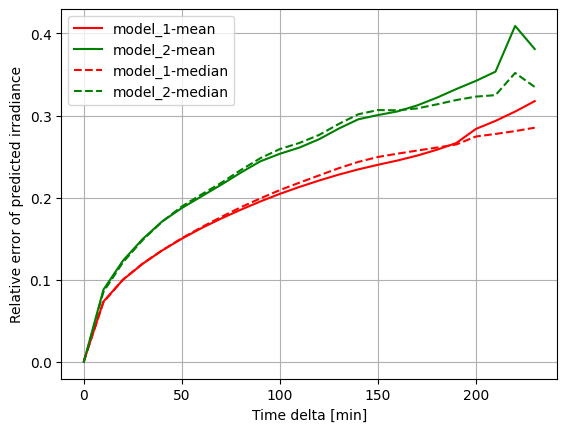

In [12]:
time_delta = np.arange(25)
model_1_mean_error_time_delta = np.zeros_like(time_delta, dtype=float)
model_2_mean_error_time_delta = np.zeros_like(time_delta, dtype=float)

model_1_median_error_time_delta = np.zeros_like(time_delta, dtype=float)
model_2_median_error_time_delta = np.zeros_like(time_delta, dtype=float)

for delta in time_delta:
    model_1_mean_error_time_delta[delta] = np.mean(global_ape_model_1[delta])
    model_2_mean_error_time_delta[delta] = np.mean(global_ape_model_2[delta])
    model_1_median_error_time_delta[delta] = np.median(global_ape_model_1[delta])
    model_2_median_error_time_delta[delta] = np.median(global_ape_model_2[delta])

plt.plot(time_delta*10,model_1_mean_error_time_delta, color='red', label='model_1-mean')
plt.plot(time_delta*10,model_2_mean_error_time_delta, color='green', label='model_2-mean')
plt.plot(time_delta*10,model_1_median_error_time_delta,'--', color='red', label='model_1-median')
plt.plot(time_delta*10,model_2_median_error_time_delta,'--', color='green', label='model_2-median')
plt.legend(loc='best')
plt.ylabel('Relative error of predicted irradiance')
plt.xlabel('Time delta [min]')
plt.grid(True)

/home/semo/anaconda3/envs/solargis37/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


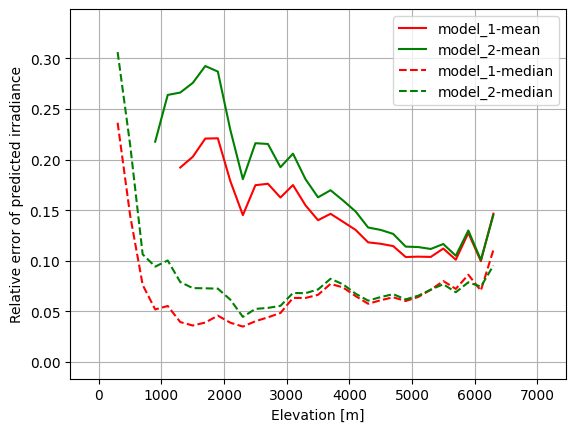

In [18]:
elevation_levels = np.arange(-100, 7200, 200)

model_1_mean_error_elevation = np.zeros_like(elevation_levels, dtype=float)
model_2_mean_error_elevation = np.zeros_like(elevation_levels, dtype=float)

model_1_median_error_elevation = np.zeros_like(elevation_levels, dtype=float)
model_2_median_error_elevation = np.zeros_like(elevation_levels, dtype=float)

for i, level in enumerate(elevation_levels[:-1]):
    elevation_mask = mask_by_elevation(elevation_levels[i+1], level)
    model_1_mean_error_elevation[i] = np.mean(global_ape_model_1[:,elevation_mask])
    model_2_mean_error_elevation[i] = np.mean(global_ape_model_2[:,elevation_mask])
    model_1_median_error_elevation[i] = np.median(global_ape_model_1[:,elevation_mask])
    model_2_median_error_elevation[i] = np.median(global_ape_model_2[:,elevation_mask])
    
plt.plot(elevation_levels,model_1_mean_error_elevation, color='red', label='model_1-mean')
plt.plot(elevation_levels,model_2_mean_error_elevation, color='green', label='model_2-mean')
plt.plot(elevation_levels,model_1_median_error_elevation,'--', color='red', label='model_1-median')
plt.plot(elevation_levels,model_2_median_error_elevation,'--', color='green', label='model_2-median')

plt.legend(loc='best')
plt.ylabel('Relative error of predicted irradiance')
plt.xlabel('Elevation [m]')
plt.grid(True)

<font size="4">In the figures seen above, there always ( or maybe max comparable) significant difference in the absolute percentage error in favor of `model_1`. Lets see the distribution of these errors. In the figures bellow we can see the systematic shift of distribution of these errors.

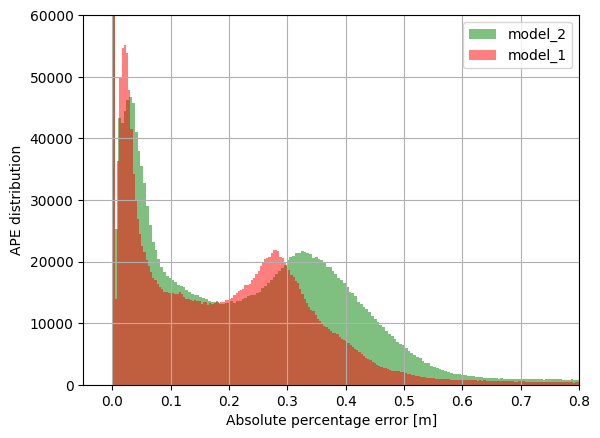

In [19]:
plt.hist(global_ape_model_2[:-1].flatten(), bins=1000, alpha=0.5, label= 'model_2', color='green')
plt.hist(global_ape_model_1[:-1].flatten(), bins=1000, alpha=0.5, label= 'model_1', color='red')
plt.xlim([-0.05,0.8])
plt.ylim([0.0,60000])
plt.legend(loc='best')
plt.ylabel('APE distribution')
plt.xlabel('Absolute percentage error [m]')
plt.grid(True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


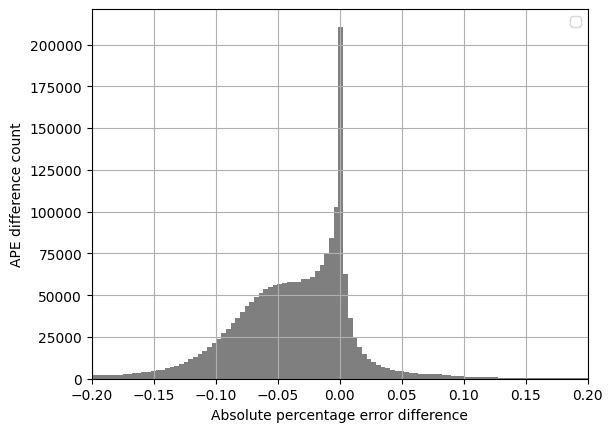

In [20]:
plt.hist((global_ape_model_1[:-1]-global_ape_model_2[:-1]).flatten(), bins=1000, alpha=0.5, color='black')
plt.xlim(-0.2, 0.2)

plt.legend(loc='best')
plt.ylabel('APE difference count')
plt.xlabel('Absolute percentage error difference')
plt.grid(True)

<font size="4">We can see that global statistics around errors are playing in favor of model 1. However can we find places which are on average better predicted by model two ? Let's find out in next figure:

Text(0.5, 1.0, 'APE global difference - model_1>model_2 mask')

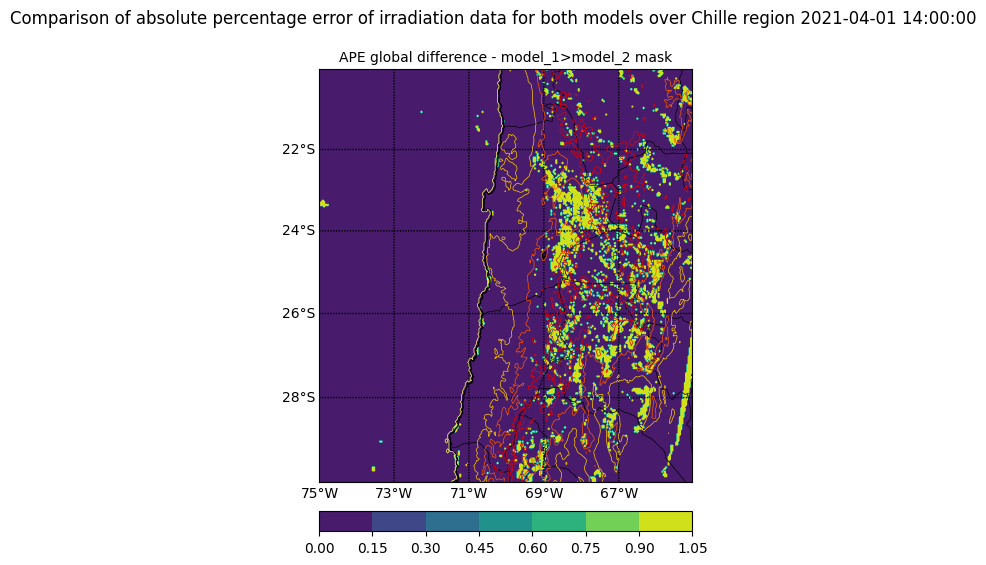

In [21]:
comparison_mask = np.mean(global_ape_model_1, axis=0)>np.mean(global_ape_model_2, axis=0)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[10,6])
fig.suptitle('Comparison of absolute percentage error of irradiation data for both models over Chille region '+ 
             str(datetime.fromtimestamp(ds.variables['reference_time'][ref_idx]*60)), fontsize=12)

plot_regional_data(comparison_mask, ax)
ax.set_title('APE global difference - model_1>model_2 mask', size=10)

In [22]:
print(f'model_1 has higher absolute percentage error over model_2 on {round(100*np.sum(comparison_mask)/comparison_mask.size, 2)} % of studied area globally')

model_1 has higher absolute percentage error over model_2 on 4.9 % of studied area globally


<font size="4">We can see in the figure above that some places are on average better predicted by model_2. For example  the area between 69W - 67W and 22S - 24S is significantly better predictable area on average. 

<font size="4"> Let's see how are the average errors in that area dependent on simulation step (time delta):

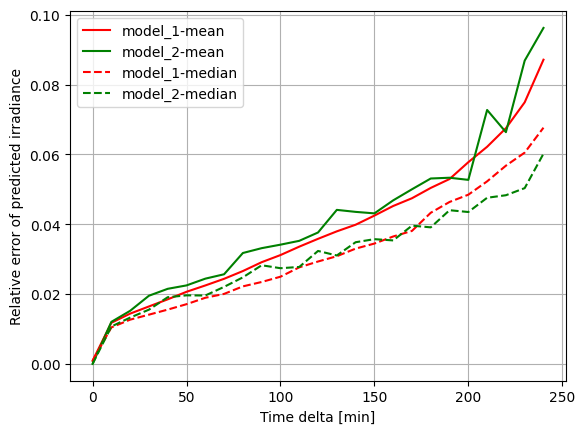

In [23]:
time_delta = np.arange(25)
lat_mask = (lat < -22)&(lat > -24)
long_mask = (long > -69)&(long < -67)

model_1_mean_error_time_delta = np.zeros_like(time_delta, dtype=float)
model_2_mean_error_time_delta = np.zeros_like(time_delta, dtype=float)

model_1_median_error_time_delta = np.zeros_like(time_delta, dtype=float)
model_2_median_error_time_delta = np.zeros_like(time_delta, dtype=float)

for delta in time_delta:
    model_1_mean_error_time_delta[delta] = np.mean(global_ape_model_1[delta, lat_mask, long_mask])
    model_2_mean_error_time_delta[delta] = np.mean(global_ape_model_2[delta, lat_mask, long_mask])
    model_1_median_error_time_delta[delta] = np.median(global_ape_model_1[delta, lat_mask, long_mask])
    model_2_median_error_time_delta[delta] = np.median(global_ape_model_2[delta, lat_mask, long_mask])

plt.plot(time_delta*10,model_1_mean_error_time_delta, color='red', label='model_1-mean')
plt.plot(time_delta*10,model_2_mean_error_time_delta, color='green', label='model_2-mean')
plt.plot(time_delta*10,model_1_median_error_time_delta,'--', color='red', label='model_1-median')
plt.plot(time_delta*10,model_2_median_error_time_delta,'--', color='green', label='model_2-median')
plt.legend(loc='best')
plt.ylabel('Relative error of predicted irradiance')
plt.xlabel('Time delta [min]')
plt.grid(True)

<font size="4">In the figure above we can see that the errors in the selected region are somewhat similar, but the tail of time delta plays in favor of `model_2`. Therefore on average `model_2` slightly outperforms `model_1`.

# Conclusion

This notebook was dedicated to analytical task for analysis and comparison of two forecasting models for solar irradiance over a selected area in Chille. 

Dataset was analysed, visualized, cleaned and used for further statistical processing. 
Metrics used for model forecasting accuracy was APE (absolute percentual error) combined with different statistical moments such as mean and median.

Based on all plots and numbers calculated above, `model_1` seems to have better accuracy compared to `model_2`, although `model_2` seems to be more complex compared to `model_1`. Also the computational complexity of `model_2` is probably higher than for `model_1`, according to number of reference points needed for `model_2` and character of structures simulated by `model_2`. However `model_2` could be probably used for more precise local weather behavior after some fine-tuning, but still model_1 outperformed `model_2` on most levels, `model_1` is better for general purposes.